# <center> Классификация сигналов оптомиографических датчиков

В данной работе мы будем решать задачу из [соревнования на Kaggle](https://www.kaggle.com/competitions/motorica-skillfactory-internship-test-task-2023-12/overview). Она заключается в классификации непрерывных команд от пользователя на основе данных, полученных от оптомиографических датчиков.

Необходимо построить модель распознавания жестов в парадигме обучения с учителем. Параметры модели должны быть оптимизированы на предложенных данных для обучения. Валидация модели должна произведиться на отложенной тестовой выборке на платформе соревнования.

## Загрузка и преобразование данных

In [29]:
# Для работы с числами и таблицами
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

# Для моделирования
from sklearn import base
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn import ensemble
from xgboost import XGBClassifier
import catboost as cb
from sklearn import metrics

# Для оптимизации моделей
import optuna
from optuna.integration import CatBoostPruningCallback

# Подавление варнов
import warnings
warnings.filterwarnings('ignore')

# Архивация моделей
import joblib

In [2]:
# факторы
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

# целевые переменные
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


`y_test` здесь являет собой не просто пример сабмита, но и ее маску: столбец классов в этом файле представляет собой случайное равномерное распределение меток, поэтому `y_test` невозможно использовать для валидации предсказаний моделей на `X_test` - предполагается, что это происходит на платформе; однако в этом файле также имеется столбец sample-timestep, отражающий истинные метки времени, напротив которых и должны располагаться в столбце классов предсказания модели.

Данные же с факторами представляют из себя трехмерные массивы. Чтобы выполнить задачу классификации, их нужно перевести в двумерный формат. 

Можно заметить, что число наблюдений в `X_train` - это просто число наблюдений из `y_ytain` поделенное на количество временных отметок в `X_train`.

А это значит, что мы сможем **вертикально соединить** каждый двумерный массив из `X_train`, находящийся на оси времени. Таким образом, мы получим таблицу, у которой размерность по оси наблюдений совпадает с целевой переменной. 

Те же самые заключения справедливы в отношении `X_test`.

Напишем класс для преобразования данных.

In [4]:
class TensorToMatrix(base.TransformerMixin):
    def __init__(self) -> None:
        """Класс-трансформер, который преобразовывает данные в удобный для обучения вид."""
        pass 
    
    
    def _check_params(self, tensor):
        """Технический метод для проверки корректности параметров.
        Args:
        ---
            tensor (`ArrayLike`): массив
        Raises:
        ---
            `ValueError`: массив должен иметь размерность 3
        """
        X_shape = len(tensor.shape)
        
        if X_shape != 3:
            raise ValueError(f'There must be 3d array, got {X_shape}d')
    
    
    def fit(self, tensor):
        """Обучение трансформера.
        Args:
        ---
            tensor (`ArrayLike`): массив 
            
        Returns:
        ---
            `self`: обученный трансформер
        """
        self._check_params(tensor)
        
        return self
    
    
    def transform(self, tensor):
        """Трансформация трехмерного массива в двумерный. 
        Args:
        ---
            tensor (`ArrayLike`): трехмерный массив
        Returns:
        ---
            `NDArray`: двумерный массив 
        """
        self._check_params(tensor)
        
        # перебираем двумерные массивы и заносим их в список
        samples = []
        
        for X in tensor:
            # добавляем в данные также временные отметки
            timesteps = np.arange(X.shape[1])
            
            # не забываем транспонировать массивы, чтобы строки и столбцы были на своих местах
            X_transformed = np.column_stack((X.T, timesteps))
            samples.append(X_transformed)
            
        # результат - вертикально соединенный массив
        return np.row_stack(samples)
    
    
    def fit_transform(self, tensor, y=None):
        return self.fit(tensor).transform(tensor)


X_train_2d = TensorToMatrix().fit_transform(X_train)
X_test_2d = TensorToMatrix().fit_transform(X_test)

Сформируем из получившихся данных соответствующие датафреймы.

In [5]:
X_train_2d_df = pd.DataFrame(X_train_2d)
X_train_2d_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0,0.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0,1.0
2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0,2.0


In [6]:
X_test_2d_df = pd.DataFrame(X_test_2d)
X_test_2d_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0,0.0
1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0,1.0
2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0,2.0


Оценим соотношение классов в `y_train`.

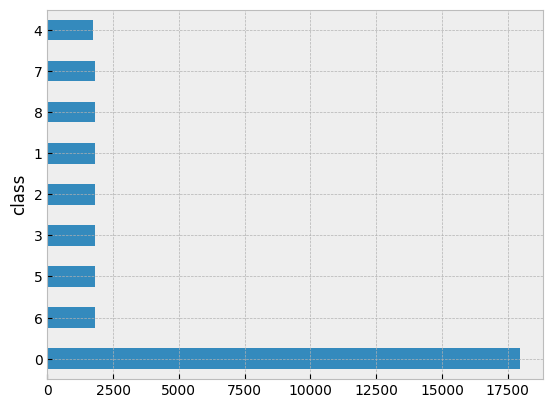

In [7]:
y_train_2d = y_train['class']

y_train_2d.value_counts().plot(kind="barh");

y_train_2d = y_train_2d.values

Класс `0`, как видим, представлен в данных на порядок чаще.

`y_train.csv` содержит следующие классы:
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

### Исходный вид

Восстановим исходный вид меток для корректной визуализации логирования показаний датчиков.

In [8]:
y_train_original = y_train.copy()

y_train_original[['sample_id', 'timestep']] = y_train_original['sample-timestep'].str.split(pat="-", n=1, expand=True).astype(int)
y_train_original = y_train_original.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train_original = y_train_original.sort_index() # на всякий случай
y_train_original = y_train_original.values

print(y_train_original.shape)
y_train_original

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

В треннировочных данных насчитывается 323 испытания, каждая из которых длится в течении ста некоторых единиц времени. Мы можем визуализировать пару из показаний датчиков и классов исполняемых команд.

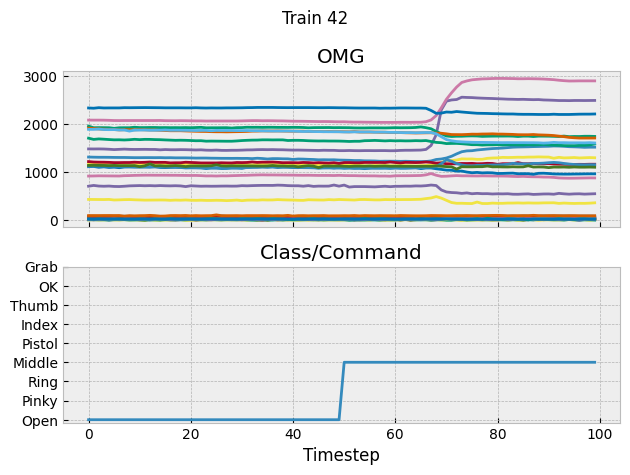

In [175]:
i = 42

fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train_original[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

Собственно, наша задача и состоит в том, чтобы предсказать, какая команда была выполнена пользователем и в какое время.

### Сглаживание, разложение и стандартизация данных

И так как мы работаем с временными рядами, нам необходимо привести данные в надлежащий вид. Мы попробуем избавиться шумов посредством сглаживания, а также воспользуемся преобразованием Фурье.

In [10]:
# Функция для экспоненциального сглаживания и преобразования Фурье
def fft2_transformer(Xdf, sample_size=100, alpha=0.3):
    samples, j = [], 0
    for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
        x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)[:-1]].ewm(alpha=alpha, adjust=True).mean().values
        fft_transformed = np.fft.fft2(x_smoothed)
        fft_real = fft_transformed.real.astype(np.float64)
        samples.append(fft_real)
        j = i
    
    X_fft2 = np.row_stack(samples)
    X_fft2 = np.column_stack((X_fft2, Xdf.values[:, -1]))
    
    return X_fft2

X_train_fft2 = fft2_transformer(X_train_2d_df)
X_test_fft2 = fft2_transformer(X_test_2d_df)

Посмотрим, что у нас получилось.

In [11]:
pd.DataFrame(X_train_fft2).head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.403834e+06,-253568.129566,240203.612086,-72631.089472,19172.431401,-50248.697014,-196688.473794,160585.504048,152866.875116,-150084.641721,...,-150084.641721,152866.875116,160585.504048,-196688.473794,-50248.697014,19172.431401,-72631.089472,240203.612086,-253568.129566,0.0
1,-5.268812e+02,409.571351,-5681.842154,-4556.154254,2201.626353,2159.663390,-1445.311287,-1375.028373,847.945157,-587.808598,...,986.709148,-486.209157,161.288089,480.454509,140.036488,-1914.516581,3210.718272,6534.796078,2504.707630,1.0
2,-1.022690e+03,-203.455306,-2473.822571,-1813.487292,412.975930,128.237186,-645.758087,-881.746776,-77.731151,-542.240945,...,904.650731,-358.604227,34.564808,323.370406,213.866479,-1139.244038,973.084792,3250.680178,1425.201991,2.0
3,-5.884574e+02,-650.010770,-1364.516289,-1263.765512,26.800064,-357.399298,-162.065399,-118.852277,-319.593396,-597.610995,...,1111.707878,225.389400,-360.949935,553.390492,732.875954,-929.362409,321.866892,2115.272542,1390.733809,3.0
4,1.268995e+03,14.711248,-1545.017943,-1048.081908,345.164337,378.998330,-205.832288,-303.568522,299.879565,117.939750,...,421.859462,137.875755,310.487218,-60.308390,-337.467282,-253.478862,1032.251523,1244.259286,675.869295,4.0


Каждая первая строка из 323 серий представляет собой выброс - виной тому алгоритм преобразования Фурье. Т.к. сигналы датчиков в первую единицу времени и во вторую всегда свидетельствуют 

In [12]:
# подготовим тренировочные данные к обучению модели
scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_fft2)
X_train_mm = mm_scaler.fit_transform(X_train_fft2)

X_test_scaled = scaler.transform(X_test_fft2)
X_test_mm = mm_scaler.transform(X_test_fft2)

### Устранение мультиколлинеарности

In [13]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_scaled, columns=list(range(41))).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 41
Ранг матрицы:   41
Определитель:   2.2918084317288362e-97


Имеется мультколлинеарность, попробуем уменьшить размерность данных.

In [14]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = PCA(n_components=0.9999, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 26


In [46]:
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_scaled_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 26
Ранг матрицы:   26
Определитель:   0.999999999999999


## Модели решения задачи классификации

In [16]:
def cv_scores(model, X, y, cv=10):
    """
    Функция кросс-валидации модели.
    Args:
        model: объект, который будет обучаться на данных;
        X (np.array): матрица данных;
        y (np.array): вектор целевой переменной;
        cv (int, cross-validation generator):
            число фолдов кросс-валидации, либо cross-validation estimator.
    Returns:
        array: вектор метрик тествовой выборки.
    """
    if str(model).split('(')[0][:4] == 'XGBC':
        le = preprocessing.LabelEncoder()
        y_le = le.fit_transform(y)
        scores = model_selection.cross_validate(
            model, X, y_le, cv=cv,
            scoring=('precision_weighted', 'recall_weighted', 'f1_weighted', 'accuracy')
        )
    else:
        scores = model_selection.cross_validate(
            model, X, y, cv=cv,
            scoring=('precision_weighted', 'recall_weighted', 'f1_weighted', 'accuracy')
        )
    
     
    precision = np.mean(scores['test_precision_weighted'])
    recall = np.mean(scores['test_recall_weighted'])
    f1 = np.mean(scores['test_f1_weighted'])
    accuracy = np.mean(scores['test_accuracy'])
    
    scores_array = np.array([precision, recall, f1, accuracy])
    
    scores_print_lst = [
        'Aggregate metrics:\n',
        f'{" "*11}Precision:{" "*5} {round(precision, 4)}',
        f'{" "*11}Recall:{" "*5}    {round(recall, 4)}',
        f'{" "*11}F1 score:{" "*5}  {round(f1, 4)}',
        f'{" "*11}Accuracy:{" "*5}  {round(accuracy, 4)}'
    ]
    
    return scores_array, scores_print_lst

### Baseline model. LogisticRegression

In [74]:
%%time
# Инициализируем объект LogisticRegression
base_logr = linear_model.LogisticRegression(
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)
# Обучение
base_logr.fit(X_train_fft2, y_train_2d)
# Предсказания
preds_train_base_logr = base_logr.predict(X_train_fft2)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, preds_train_base_logr, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')
# Получение метрик
scores_array_logr, print_logr_scores = cv_scores(
    base_logr, X_train_fft2, y_train_2d
)

# Вывод агрегированных метрик 
print(*print_logr_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.9218    0.9511    0.9362     17950
           1     0.8523    0.7883    0.8190      1800
           2     0.9200    0.8694    0.8940      1800
           3     0.9231    0.9067    0.9148      1800
           4     0.8743    0.8549    0.8645      1750
           5     0.8956    0.8533    0.8740      1800
           6     0.8214    0.7894    0.8051      1800
           7     0.8906    0.8322    0.8604      1800
           8     0.9092    0.9128    0.9110      1800

    accuracy                         0.9066     32300
   macro avg     0.8898    0.8620    0.8755     32300
weighted avg     0.9058    0.9066    0.9058     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.8831
           Recall:         0.8831
           F1 score:       0.881
           Accuracy:       0.8831

CPU times: total: 5min 57s
Wall time: 3min 15s


### GaussianNB

In [75]:
%%time
# Инициализация объекта
gnb = GaussianNB()
# Обучение
gnb.fit(X_train_2d, y_train_2d)
# Предсказания
gnb_preds_train = gnb.predict(X_train_2d)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, gnb_preds_train, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_gnb, print_gnb_scores = cv_scores(
    gnb, X_train_2d, y_train_2d
)

# Вывод агрегированных метрик
print(*print_gnb_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.8213    0.7738    0.7968     17950
           1     0.7224    0.6461    0.6821      1800
           2     0.8066    0.7344    0.7688      1800
           3     0.7729    0.7978    0.7851      1800
           4     0.5230    0.7023    0.5995      1750
           5     0.5885    0.5322    0.5589      1800
           6     0.6351    0.5744    0.6033      1800
           7     0.3981    0.5972    0.4778      1800
           8     0.6844    0.7506    0.7160      1800

    accuracy                         0.7263     32300
   macro avg     0.6614    0.6788    0.6654     32300
weighted avg     0.7415    0.7263    0.7312     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.7479
           Recall:         0.6987
           F1 score:       0.7004
           Accuracy:       0.6987

CPU times: total: 359 ms
Wall time: 360 ms


### KNeighborsClassifier

In [76]:
%%time
# Инициализация объекта
knn = KNeighborsClassifier()
# Обучение
knn.fit(X_train_scaled, y_train_2d)
# Предсказания
knn_preds_train = knn.predict(X_train_scaled)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, knn_preds_train, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_knn, print_knn_scores = cv_scores(
    knn, X_train_scaled, y_train_2d
)

# Вывод агрегированных метрик
print(*print_knn_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.9990    0.9996    0.9993     17950
           1     0.9922    0.9939    0.9931      1800
           2     0.9989    0.9956    0.9972      1800
           3     0.9983    1.0000    0.9992      1800
           4     0.9971    0.9834    0.9902      1750
           5     0.9770    0.9894    0.9832      1800
           6     0.9972    0.9956    0.9964      1800
           7     0.9876    0.9767    0.9821      1800
           8     0.9906    0.9978    0.9942      1800

    accuracy                         0.9960     32300
   macro avg     0.9931    0.9924    0.9928     32300
weighted avg     0.9960    0.9960    0.9960     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.9836
           Recall:         0.982
           F1 score:       0.9819
           Accuracy:       0.982

CPU times: total: 11.9 s
Wall time: 2.16 s


### LinearSVC

In [77]:
%%time
# Инициализация объекта
lin_svc = svm.LinearSVC(
    dual='auto',
    max_iter=3000,
    random_state=42
)
# Обучение
lin_svc.fit(X_train_2d, y_train_2d)
# Предсказания
lin_svc_preds_train = lin_svc.predict(X_train_2d)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, lin_svc_preds_train, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_lin_svc, print_lin_svc_scores = cv_scores(
    lin_svc, X_train_2d, y_train_2d
)

# Вывод агрегированных метрик
print(*print_lin_svc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.8140    0.8833    0.8472     17950
           1     0.8124    0.5317    0.6427      1800
           2     0.8269    0.7617    0.7929      1800
           3     0.8227    0.8144    0.8185      1800
           4     0.8434    0.7634    0.8014      1750
           5     0.8227    0.7839    0.8028      1800
           6     0.8026    0.6889    0.7414      1800
           7     0.8084    0.7522    0.7793      1800
           8     0.8452    0.7917    0.8176      1800

    accuracy                         0.8178     32300
   macro avg     0.8220    0.7524    0.7827     32300
weighted avg     0.8180    0.8178    0.8149     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.8078
           Recall:         0.8001
           F1 score:       0.7963
           Accuracy:       0.8001

CPU times: total: 25.3 s
Wall time: 25.3 s


### SVC

In [78]:
%%time
# Инициализация объекта
svc = svm.SVC(
    kernel='rbf',
    random_state=42
)
# Обучение
svc.fit(X_train_2d, y_train_2d)
# Предсказания
svc_preds_train = svc.predict(X_train_2d)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, svc_preds_train, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_svc, print_svc_scores = cv_scores(
    svc, X_train_2d, y_train_2d
)

# Вывод агрегированных метрик
print(*print_svc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.8200    0.8803    0.8491     17950
           1     0.8172    0.7450    0.7794      1800
           2     0.8394    0.7722    0.8044      1800
           3     0.8270    0.8100    0.8184      1800
           4     0.8505    0.7446    0.7940      1750
           5     0.8090    0.8000    0.8045      1800
           6     0.8033    0.6217    0.7009      1800
           7     0.8185    0.7389    0.7766      1800
           8     0.8422    0.7678    0.8033      1800

    accuracy                         0.8224     32300
   macro avg     0.8252    0.7645    0.7923     32300
weighted avg     0.8226    0.8224    0.8207     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.8112
           Recall:         0.8105
           F1 score:       0.8059
           Accuracy:       0.8105

CPU times: total: 3min 11s
Wall time: 3min 11s


### SGDClassifier

In [79]:
%%time
# Инициализация объекта
sgdc = linear_model.SGDClassifier(
    loss='log_loss',
    random_state=42
)
# Обучение
sgdc.fit(X_train_2d, y_train_2d)
# Предсказания
sgdc_preds_train = sgdc.predict(X_train_2d)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, sgdc_preds_train, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_sgdc, print_sgdc_scores = cv_scores(
    sgdc, X_train_2d, y_train_2d
)

# Вывод агрегированных метрик
print(*print_sgdc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.7713    0.7287    0.7494     17950
           1     0.2708    0.8644    0.4125      1800
           2     0.8327    0.7022    0.7619      1800
           3     0.8264    0.7961    0.8110      1800
           4     0.9046    0.3954    0.5503      1750
           5     0.8200    0.7544    0.7859      1800
           6     0.8260    0.2928    0.4323      1800
           7     0.8028    0.7350    0.7674      1800
           8     0.8565    0.7794    0.8162      1800

    accuracy                         0.7008     32300
   macro avg     0.7679    0.6721    0.6763     32300
weighted avg     0.7694    0.7008    0.7131     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.7524
           Recall:         0.7036
           F1 score:       0.6983
           Accuracy:       0.7036

CPU times: total: 51.5 s
Wall time: 51.5 s


### MLPClassifier

In [82]:
%%time
# Инициализация объекта
mlpc = MLPClassifier(
    hidden_layer_sizes=(369, 41),
    activation='relu',
    max_iter=600,
    random_state=42
)
# Обучение
mlpc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
mlpc_preds_train = mlpc.predict(X_train_scaled_pca)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, mlpc_preds_train, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_mlpc, print_mlpc_scores = cv_scores(
    mlpc, X_train_scaled_pca, y_train_2d
)

# Вывод агрегированных метрик
print(*print_mlpc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     17950
           1     0.9994    1.0000    0.9997      1800
           2     1.0000    1.0000    1.0000      1800
           3     1.0000    1.0000    1.0000      1800
           4     1.0000    0.9989    0.9994      1750
           5     1.0000    1.0000    1.0000      1800
           6     0.9994    1.0000    0.9997      1800
           7     1.0000    0.9994    0.9997      1800
           8     0.9994    1.0000    0.9997      1800

    accuracy                         0.9999     32300
   macro avg     0.9998    0.9998    0.9998     32300
weighted avg     0.9999    0.9999    0.9999     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.9848
           Recall:         0.9834
           F1 score:       0.9831
           Accuracy:       0.9834

CPU times: total: 9min 24s
Wall time: 4min 31s


In [83]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_mlp(trial):
    """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    
    # Задаем пространствао поиска гиперпараметров
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(369, 41)]),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2),
        'max_iter': trial.suggest_categorical('max_iter', [600]),
    }
    
    # Создаем модель
    model=MLPClassifier(
        **params,
        random_state=42        
    )
    # Рассчитаем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        model, X_train_scaled_pca, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
    ).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_mlp = optuna.create_study(study_name="mlp_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_mlp.optimize(optuna_mlp, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_mlp = MLPClassifier(**study_mlp.best_params, random_state=42)
# Обучение
opt_mlp.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_opt_mlp = opt_mlp.predict(X_train_scaled_pca)

# Вывод метрик
print('Best params:', study_mlp.best_params)
report = metrics.classification_report(
    y_train_2d, preds_train_opt_mlp, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_opt_mlp, print_opt_mlp_scores = cv_scores(
    opt_mlp, X_train_scaled_pca, y_train_2d
)

# Вывод агрегированных метрик
print(*print_opt_mlp_scores, sep='\n', end='\n\n')

Best params: {'hidden_layer_sizes': (369, 41), 'alpha': 0.009880002734676693, 'max_iter': 600}
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     17950
           1     0.9994    0.9994    0.9994      1800
           2     1.0000    1.0000    1.0000      1800
           3     1.0000    0.9978    0.9989      1800
           4     0.9954    1.0000    0.9977      1750
           5     0.9994    0.9989    0.9992      1800
           6     0.9994    1.0000    0.9997      1800
           7     0.9994    0.9994    0.9994      1800
           8     1.0000    0.9956    0.9978      1800

    accuracy                         0.9995     32300
   macro avg     0.9992    0.9990    0.9991     32300
weighted avg     0.9995    0.9995    0.9995     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.9856
           Recall:         0.9838
           F1 score:       0.9

In [84]:
# Сохранение модели
joblib.dump(opt_mlp, "opt_mlp.pkl")

['opt_mlp.pkl']

### DecisionTreeClassifier

In [85]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_dtc(trial):
    """Функция, обучающая модель DecisionTreeClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 2, 49),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 51, 2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)    
    }

    # Создаем модель
    model=tree.DecisionTreeClassifier(
        **params,
        random_state=42        
    )   
    # Рассчитаем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        model, X_train_scaled_pca, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
    ).mean()
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_dtc = optuna.create_study(study_name="dtc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_dtc.optimize(optuna_dtc, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_dtc = tree.DecisionTreeClassifier(**study_dtc.best_params, random_state=42)
# Обучение
opt_dtc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_opt_dtc = opt_dtc.predict(X_train_scaled_pca)

# Вывод метрик
print('Best params:', study_dtc.best_params)
report = metrics.classification_report(
    y_train_2d, preds_train_opt_dtc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_opt_dtc, print_opt_dtc_scores = cv_scores(
    opt_dtc, X_train_scaled_pca, y_train_2d
)

# Вывод агрегированных метрик
print(*print_opt_dtc_scores, sep='\n', end='\n\n')

Best params: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}
Classification Report:
               precision    recall  f1-score   support

           0     0.9963    0.9979    0.9971     17950
           1     0.9838    0.9811    0.9825      1800
           2     0.9894    0.9889    0.9892      1800
           3     0.9928    0.9944    0.9936      1800
           4     0.9823    0.9829    0.9826      1750
           5     0.9844    0.9833    0.9839      1800
           6     0.9844    0.9844    0.9844      1800
           7     0.9860    0.9772    0.9816      1800
           8     0.9883    0.9833    0.9858      1800

    accuracy                         0.9919     32300
   macro avg     0.9875    0.9859    0.9867     32300
weighted avg     0.9919    0.9919    0.9919     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.9183
           Recall:         0.9178
  

In [86]:
# Сохранение модели
joblib.dump(opt_dtc, "opt_dtc.pkl")

['opt_dtc.pkl']

### RandomForestClassifier

In [94]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_rfc(trial):
    """Функция, обучающая модель RandomForestClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, 25),
        'max_depth': trial.suggest_int('max_depth', 2, 48, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, 1)
    }

    # Создаем модель
    model=ensemble.RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )
    # Рассчитаем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        model, X_train_mm, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
    ).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_rfc = optuna.create_study(study_name="rfc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rfc.optimize(optuna_rfc, n_trials=20)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_rfc = ensemble.RandomForestClassifier(**study_rfc.best_params, random_state=42)
# Обучение
opt_rfc.fit(X_train_mm, y_train_2d)
# Предсказания
preds_train_opt_rfc = opt_rfc.predict(X_train_mm)

# Получение метрик
scores_array_opt_rfc, print_opt_rfc_scores = cv_scores(
    opt_rfc, X_train_mm, y_train_2d
)

# Вывод метрик
print(f'Лучшие гиперпараметры: {study_rfc.best_params}')
report = metrics.classification_report(
    y_train_2d, preds_train_opt_rfc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Вывод агрегированных метрик
print(*print_opt_rfc_scores, sep='\n', end='\n\n')

Лучшие гиперпараметры: {'criterion': 'log_loss', 'n_estimators': 250, 'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4}
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    1.0000    0.9999     17950
           1     1.0000    1.0000    1.0000      1800
           2     1.0000    0.9994    0.9997      1800
           3     1.0000    1.0000    1.0000      1800
           4     1.0000    0.9994    0.9997      1750
           5     1.0000    1.0000    1.0000      1800
           6     1.0000    1.0000    1.0000      1800
           7     1.0000    1.0000    1.0000      1800
           8     1.0000    1.0000    1.0000      1800

    accuracy                         0.9999     32300
   macro avg     1.0000    0.9999    0.9999     32300
weighted avg     0.9999    0.9999    0.9999     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.9735
           Recall:       

In [95]:
# Сохранение модели
joblib.dump(opt_rfc, "opt_rfc.pkl")

['opt_rfc.pkl']

### HistGradientBoostingClassifier

In [24]:
%%time
# Инициализация объекта
hgbc = ensemble.HistGradientBoostingClassifier(
    random_state=42
)
# Обучение
hgbc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_hgbc = hgbc.predict(X_train_scaled_pca)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, preds_train_hgbc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_hgbc, print_hgbc_scores = cv_scores(
    hgbc, X_train_scaled_pca, y_train_2d
)

# Вывод агрегированных метрик
print(*print_hgbc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9999     17950
           1     0.9994    0.9961    0.9978      1800
           2     0.9983    0.9994    0.9989      1800
           3     0.9989    1.0000    0.9994      1800
           4     0.9994    0.9989    0.9991      1750
           5     0.9972    0.9994    0.9983      1800
           6     0.9994    0.9978    0.9986      1800
           7     0.9994    0.9989    0.9992      1800
           8     1.0000    0.9989    0.9994      1800

    accuracy                         0.9994     32300
   macro avg     0.9991    0.9988    0.9990     32300
weighted avg     0.9994    0.9994    0.9994     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.9814
           Recall:         0.9803
           F1 score:       0.9798
           Accuracy:       0.9803

CPU times: total: 3min 26s
Wall time: 37.9 s


In [38]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_hgbc(trial):
    """Функция, обучающая модель HistGradientBoostingClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    params = {
       'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 101, 2),
        'l2_regularization': trial.suggest_float('l2_regularization', 0, 1)    
    }

    # Создаем модель
    model=ensemble.HistGradientBoostingClassifier(
        **params,
        random_state=42
    )
    # Рассчитаем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        model, X_train_scaled_pca, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
    ).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_hgbc = optuna.create_study(study_name="hgbc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_hgbc.optimize(optuna_hgbc, n_trials=50)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_hgbc = ensemble.HistGradientBoostingClassifier(
    **study_hgbc.best_params,
    random_state=42
)
# Обучение
opt_hgbc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_opt_hgbc = opt_hgbc.predict(X_train_scaled_pca)

# Получение метрик
scores_array_opt_hgbc, print_opt_hgbc_scores = cv_scores(
    opt_hgbc, X_train_scaled_pca, y_train_2d
)

# Вывод метрик
print('Best params:', study_hgbc.best_params)
report = metrics.classification_report(
    y_train_2d, preds_train_opt_hgbc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Вывод агрегированных метрик
print(*print_opt_hgbc_scores, sep='\n', end='\n\n')

Best params: {'learning_rate': 0.09702675681193391, 'max_iter': 725, 'max_leaf_nodes': 14, 'max_depth': 7, 'min_samples_leaf': 85, 'l2_regularization': 0.00023162329443535048}
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     17950
           1     0.9994    0.9961    0.9978      1800
           2     0.9983    0.9994    0.9989      1800
           3     0.9978    1.0000    0.9989      1800
           4     1.0000    0.9983    0.9991      1750
           5     0.9978    0.9989    0.9983      1800
           6     1.0000    0.9978    0.9989      1800
           7     0.9989    0.9983    0.9986      1800
           8     1.0000    0.9989    0.9994      1800

    accuracy                         0.9993     32300
   macro avg     0.9991    0.9986    0.9989     32300
weighted avg     0.9993    0.9993    0.9993     32300

------------------------------------------------------- 

Aggregate metrics:

           Precis

Снова получается вполне симпатично. Сохраним модель.

In [39]:
# Сохранение модели
joblib.dump(opt_hgbc, "opt_hgbc.pkl")

['opt_hgbc.pkl']

### XGBClassifier

In [36]:
%%time
# Инициализация объекта
xgbc = XGBClassifier(
    seed=42
)
# Обучение
xgbc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_xgbc = xgbc.predict(X_train_scaled_pca)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, preds_train_xgbc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_xgbc, print_xgbc_scores = cv_scores(
    xgbc, X_train_scaled_pca, y_train_2d
)

# Вывод агрегированных метрик
print(*print_xgbc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     17950
           1     1.0000    1.0000    1.0000      1800
           2     1.0000    1.0000    1.0000      1800
           3     1.0000    1.0000    1.0000      1800
           4     1.0000    1.0000    1.0000      1750
           5     1.0000    1.0000    1.0000      1800
           6     1.0000    1.0000    1.0000      1800
           7     1.0000    1.0000    1.0000      1800
           8     1.0000    1.0000    1.0000      1800

    accuracy                         1.0000     32300
   macro avg     1.0000    1.0000    1.0000     32300
weighted avg     1.0000    1.0000    1.0000     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.979
           Recall:         0.9779
           F1 score:       0.9774
           Accuracy:       0.9779

CPU times: total: 2min 14s
Wall time: 12.4 s


In [40]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_xgbc(trial):
    """Функция, обучающая модель XGBClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 18, 1),
        'gamma': trial.suggest_float('gamma', 1, 9),
        'reg_alpha': trial.suggest_int('reg_alpha', 40, 180, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1001, 25)
    }

    # Создаем модель
    model=XGBClassifier(
        **params,
        seed=42
    )
    # Рассчитаем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        model, X_train_scaled_pca, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
    ).mean()
    return score

# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_xgbc = optuna.create_study(study_name="xgbc_opt", direction="maximize")
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_xgbc.optimize(optuna_xgbc, n_trials=30)

# Передаем модели коллекцию оптимальных гиперпараметров
opt_xgbc = XGBClassifier(**study_xgbc.best_params)
# Обучение
opt_xgbc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_opt_xgbc = opt_xgbc.predict(X_train_scaled_pca)

# Получение метрик
scores_array_opt_xgbc, print_opt_xgbc_scores = cv_scores(
    opt_xgbc, X_train_scaled_pca, y_train_2d
)

# Вывод метрик
print(f'Лучшие гиперпараметры: {study_xgbc.best_params}')
report = metrics.classification_report(
    y_train_2d, preds_train_opt_xgbc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Вывод агрегированных метрик
print(*print_opt_xgbc_scores, sep='\n', end='\n\n')

Лучшие гиперпараметры: {'max_depth': 16, 'gamma': 2.498466400869262, 'reg_alpha': 40, 'reg_lambda': 0.5508615687942817, 'colsample_bytree': 0.9183251557851972, 'min_child_weight': 10, 'n_estimators': 775}
Classification Report:
               precision    recall  f1-score   support

           0     0.9830    0.9965    0.9897     17950
           1     0.9636    0.8983    0.9298      1800
           2     0.9582    0.9550    0.9566      1800
           3     0.9740    0.9767    0.9753      1800
           4     0.9702    0.9491    0.9596      1750
           5     0.9589    0.9472    0.9530      1800
           6     0.9823    0.9567    0.9693      1800
           7     0.9674    0.9411    0.9541      1800
           8     0.9612    0.9783    0.9697      1800

    accuracy                         0.9760     32300
   macro avg     0.9688    0.9554    0.9619     32300
weighted avg     0.9759    0.9760    0.9758     32300

------------------------------------------------------- 

Aggregat

In [41]:
# Сохранение модели
joblib.dump(opt_xgbc, "opt_xgbc.pkl")

['opt_xgbc.pkl']

### CatBoostClassifier

In [73]:
%%time
# Инициализация объекта
cbc = cb.CatBoostClassifier(
    verbose=False,
    random_state=42
)
# Обучение
cbc.fit(X_train_scaled_pca, y_train_2d)
# Предсказания
preds_train_cbc = cbc.predict(X_train_scaled_pca)

# Вывод метрик
report = metrics.classification_report(
    y_train_2d, preds_train_cbc, digits=4
)
print("Classification Report:\n", report)
print('-'*55, '\n')

# Получение метрик
scores_array_cbc, print_cbc_scores = cv_scores(
    cbc, X_train_scaled_pca, y_train_2d
)

# Вывод агрегированных метрик
print(*print_cbc_scores, sep='\n', end='\n\n')

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     17950
           1     1.0000    1.0000    1.0000      1800
           2     1.0000    1.0000    1.0000      1800
           3     1.0000    1.0000    1.0000      1800
           4     1.0000    1.0000    1.0000      1750
           5     1.0000    1.0000    1.0000      1800
           6     1.0000    1.0000    1.0000      1800
           7     1.0000    1.0000    1.0000      1800
           8     1.0000    1.0000    1.0000      1800

    accuracy                         1.0000     32300
   macro avg     1.0000    1.0000    1.0000     32300
weighted avg     1.0000    1.0000    1.0000     32300

------------------------------------------------------- 

Aggregate metrics:

           Precision:      0.985
           Recall:         0.9841
           F1 score:       0.9838
           Accuracy:       0.9841

CPU times: total: 34min 53s
Wall time: 3min 48s


### Селекция

Сведем в единую таблицу метрики всех моделей.

In [88]:
results = pd.DataFrame(
    index=['Baseline LogReg', 'GaussianNB', 'KNeighborsClassifier', 'LinearSVC',
           'SVC', 'SGDClassifier', 'MLPClassifier', 'Optuna(MLPC)',
           'Optuna(DTC)', 'Optuna(RFC)', 'HistGradientBoostingClassifier', 'Optuna(HGBC)',
           'XGBClassifier', 'Optuna(XGBC)', 'CatBoostClassifier'],
    columns=['precision', 'recall', 'f1', 'accuracy'],
    data=[
        list(np.round(scores_array_logr, 4)), list(np.round(scores_array_gnb, 4)),
        list(np.round(scores_array_knn, 4)), list(np.round(scores_array_lin_svc, 4)),
        list(np.round(scores_array_svc, 4)), list(np.round(scores_array_sgdc, 4)),
        list(np.round(scores_array_mlpc, 4)), list(np.round(scores_array_opt_mlp, 4)),
        list(np.round(scores_array_opt_dtc, 4)), list(np.round(scores_array_opt_rfc, 4)),
        list(np.round(scores_array_hgbc, 4)), list(np.round(scores_array_opt_hgbc, 4)),
        list(np.round(scores_array_xgbc, 4)), list(np.round(scores_array_opt_xgbc, 4)),
        list(np.round(scores_array_cbc, 4))
    ]
)

results

,precision,recall,f1,accuracy
Baseline LogReg,0.8831,0.8831,0.8810,0.8831
GaussianNB,0.7479,0.6987,0.7004,0.6987
KNeighborsClassifier,0.9836,0.9820,0.9819,0.9820
LinearSVC,0.8078,0.8001,0.7963,0.8001
SVC,0.8112,0.8105,0.8059,0.8105
SGDClassifier,0.7524,0.7036,0.6983,0.7036
MLPClassifier,0.9848,0.9834,0.9831,0.9834
Optuna(MLPC),0.9856,0.9838,0.9836,0.9838
Optuna(DTC),0.9183,0.9178,0.9168,0.9178
Optuna(RFC),0.9735,0.9722,0.9715,0.9722


### StackingClassifier

In [89]:
# Список моделей для стэка
estimators = [
    ('knn', knn), ('mlpc', mlpc), ('opt_mlp', opt_mlp), ('hgbc', hgbc),
    ('opt_hgbc', opt_hgbc), ('opt_xgbc', opt_xgbc), ('cbc', cbc)
]
# Инициализация объекта
sc_metamodel = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        random_state=42
    ),
    n_jobs=-1
)

# Получение метрик
_, print_scmm_scores = cv_scores(
    sc_metamodel, X_train_scaled_pca, y_train_2d
)

# Вывод метрик
print(*print_scmm_scores, sep='\n', end='\n\n')

Aggregate metrics:

           Precision:      0.9914
           Recall:         0.9903
           F1 score:       0.9903
           Accuracy:       0.9903



In [ ]:
# Сохранение модели
joblib.dump(sc_metamodel, "sc_metamodel.pkl")

## Предсказание на тестовой выборке

In [90]:
# Предсказание загружаемой модели
# model = joblib.load("---.pkl")
# y_pred = model.predict(X_test_scaled_pca)

# сделаем предсказание классов на тестовой выборке
y_pred = sc_metamodel.predict(X_test_scaled_pca)

### Переход от исходного вида к kaggle

In [157]:
y_test_preds = []
for idx, arr in zip(y_test.index, y_pred):
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    y_test_preds.append(series)

y_test_preds = pd.concat(y_test_preds)
y_test_preds = y_test_preds.reset_index()
y_test_preds.columns = ["sample-timestep", "class"]
y_test_preds['sample-timestep'] = y_test['sample-timestep']
y_test_preds.head()

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4


In [158]:
y_test_preds['class'].value_counts()

class
0    2999
7     310
6     303
4     300
1     300
3     300
2     300
8     300
5     288
Name: count, dtype: int64

Структура индекса совпадает с образцом

In [93]:
# сохраним результат для отправки на платформу Kaggle
y_test_preds.to_csv('test_preds_sc_metamodel.csv', index=False)

## Визуализация результата моделирования

In [94]:
# подготовим данные
y_test_preds[['sample_id', 'timestep']] = y_test_preds['sample-timestep'].str.split(pat='-', n=1, expand=True).astype(int)
y_test_preds = y_test_preds.pivot(index='sample_id', columns='timestep', values='class')
y_test_index = y_test.index
y_test_preds = y_test_preds.sort_index() # на всякий случай
y_test_preds = y_test_preds.values

Изменяя параметр i можно увидеть классифицированный результат i-того измерения положения руки оператора

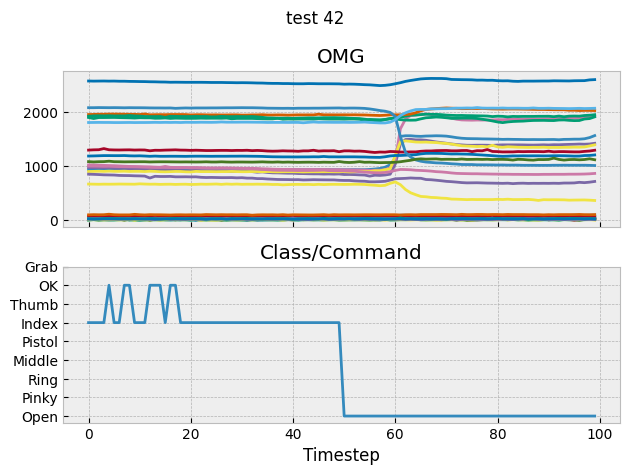

In [156]:
i = 42

fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_test_preds[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'test {i}')

plt.tight_layout()

Организаторы соревнования не опубликовали истинные метки для тестовой выборки, поэтому мы не можем достоверно проверить точность предсказаний нашей модели. Однако у нас остается косвенный метод сделать это - оценить визуально получившуюся интерпретацию моделью сигналов датчиков: чем более чистый, лишенный мгновенных пиков или впадин, получается картина на нижнем графике, тем более точной, судя по всему, является предсказание. Аналогичная визуализация треннировочной выборки не имеет подобных аномалий и состоит только из четких одиночных переключений между классами жестов, т.е. жест руки за время наблюдения меняется лишь раз: наша модель должна уметь четко различать сигналы жестов, чтобы не вносить в предсказания более одного стабильного изменения жеста за время наблюдения.

В 42-м испытании, как мы видим, присутствуют колебания на отрезке 0-20: скорее всего, это ошибки нашей модели. В наших предсказаниях всего 9 из 53 серий испытаний имеют подозрительные колебания в графике: по большей части это одиночные пики, 42-й ряд зашумлен сильнее прочих.